
<a id='heavy-tails'></a>

# Heavy-Tailed Distributions


<a id='index-0'></a>

## Contents

- [Heavy-Tailed Distributions](#Heavy-Tailed-Distributions)  
  - [Overview](#Overview)  
  - [Visual Comparisons](#Visual-Comparisons)  
  - [Failure of the LLN](#Failure-of-the-LLN)  
  - [Classifying Tail Properties](#Classifying-Tail-Properties)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon
!pip install --upgrade yfinance

Solving environment: done

# All requested packages already installed.

Requirement already up-to-date: yfinance in /Users/shuhu/anaconda3/lib/python3.8/site-packages (0.1.55)


## Overview

Most commonly used probability distributions in classical statistics and
the natural sciences have either bounded support or light tails.

When a distribution is light-tailed, extreme observations are rare and
draws tend not to deviate too much from the mean.

Having internalized these kinds of distributions, many researchers and
practitioners use rules of thumb such as “outcomes more than four or five
standard deviations from the mean can safely be ignored.”

However, some distributions encountered in economics have far more probability
mass in the tails than distributions like the normal distribution.

With such **heavy-tailed** distributions, what would be regarded as extreme
outcomes for someone accustomed to thin tailed distributions occur relatively
frequently.

Examples of heavy-tailed distributions observed in economic and financial
settings include

- the income distributions and the wealth distribution (see, e.g., [[Vil96]](https://python.quantecon.org/zreferences.html#pareto1896cours), [[BB18]](https://python.quantecon.org/zreferences.html#benhabib2018skewed)),  
- the firm size distribution ([[Axt01]](https://python.quantecon.org/zreferences.html#axtell2001zipf), [[Gab16]](https://python.quantecon.org/zreferences.html#gabaix2016power)}),  
- the distribution of returns on holding assets over short time horizons ([[Man63]](https://python.quantecon.org/zreferences.html#mandelbrot1963variation), [[Rac03]](https://python.quantecon.org/zreferences.html#rachev2003handbook)), and  
- the distribution of city sizes ([[RRGM11]](https://python.quantecon.org/zreferences.html#rozenfeld2011area), [[Gab16]](https://python.quantecon.org/zreferences.html#gabaix2016power)).  


These heavy tails turn out to be important for our understanding of economic outcomes.

As one example, the heaviness of the tail in the wealth distribution is one
natural measure of inequality.

It matters for taxation and redistribution
policies, as well as for flow-on effects for productivity growth, business
cycles, and political economy

- see, e.g., [[AR02]](https://python.quantecon.org/zreferences.html#acemoglu2002political), [[GSS03]](https://python.quantecon.org/zreferences.html#glaeser2003injustice), [[BEGS18]](https://python.quantecon.org/zreferences.html#bhandari2018inequality) or [[AKM+18]](https://python.quantecon.org/zreferences.html#ahn2018inequality).  


This lecture formalizes some of the concepts introduced above and reviews the
key ideas.

Let’s start with some imports:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline

The following two lines can be added to avoid an annoying FutureWarning, and prevent a specific compatibility issue between pandas and matplotlib from causing problems down the line:

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Visual Comparisons

One way to build intuition on the difference between light and heavy tails is
to plot independent draws and compare them side-by-side.

### A Simulation

The figure below shows a simulation.  (You will be asked to replicate it in
the exercises.)

The top two subfigures each show 120 independent draws from the normal distribution, which is light-tailed.

The bottom subfigure shows 120 independent draws from [the Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution), which is heavy-tailed.


<a id='light-heavy-fig1'></a>
![https://python.quantecon.org/_static/lecture_specific/heavy_tails/light_heavy_fig1.png](https://python.quantecon.org/_static/lecture_specific/heavy_tails/light_heavy_fig1.png)

  
In the top subfigure, the standard deviation of the normal distribution is 2,
and the draws are clustered around the mean.

In the middle subfigure, the standard deviation is increased to 12 and, as expected, the amount of dispersion rises.

The bottom subfigure, with the Cauchy draws, shows a
different pattern: tight clustering around the mean for the great majority of
observations, combined with a few sudden large deviations from the mean.

This is typical of a heavy-tailed distribution.

### Heavy Tails in Asset Returns

Next let’s look at some financial data.

Our aim is to plot the daily change in the price of Amazon (AMZN) stock for
the period from 1st January 2015 to 1st November 2019.

This equates to daily returns if we set dividends aside.

The code below produces the desired plot using Yahoo financial data via the `yfinance` library.

[*********************100%***********************]  1 of 1 completed


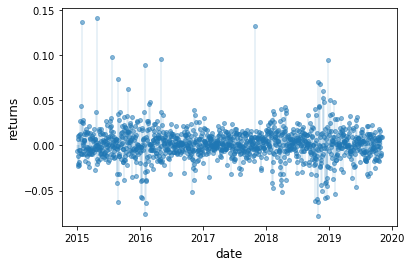

In [4]:
import yfinance as yf
import pandas as pd

s = yf.download('AMZN', '2015-1-1', '2019-11-1')['Adj Close']

r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)

ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

Five of the 1217 observations are more than 5 standard
deviations from the mean.

Overall, the figure is suggestive of heavy tails,
although not to the same degree as the Cauchy distribution the
figure above.

If, however, one takes tick-by-tick data rather
daily data, the heavy-tailedness of the distribution increases further.

## Failure of the LLN

One impact of heavy tails is that sample averages can be poor estimators of
the underlying mean of the distribution.

To understand this point better, recall [our earlier discussion](https://python.quantecon.org/lln_clt.html) of the Law of Large Numbers, which considered IID $ X_1,
\ldots, X_n $ with common distribution $ F $

If $ \mathbb E |X_i| $ is finite, then
the sample mean $ \bar X_n := \frac{1}{n} \sum_{i=1}^n X_i $ satisfies


<a id='equation-lln-as2'></a>
$$
\mathbb P \left\{ \bar X_n \to \mu \text{ as } n \to \infty \right\} = 1 \tag{1}
$$

where $ \mu := \mathbb E X_i = \int x F(x) $ is the common mean of the sample.

The condition $ \mathbb E | X_i | = \int |x| F(x) < \infty $ holds
in most cases but can fail if the distribution $ F $ is very heavy tailed.

For example, it fails for the Cauchy distribution.

Let’s have a look at the behavior of the sample mean in this case, and see
whether or not the LLN is still valid.

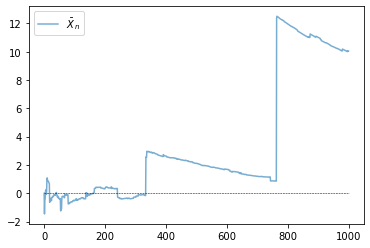

In [5]:
from scipy.stats import cauchy

np.random.seed(1234)
N = 1_000

distribution = cauchy()

fig, ax = plt.subplots()
data = distribution.rvs(N)

# Compute sample mean at each n
sample_mean = np.empty(N)
for n in range(1, N):
    sample_mean[n] = np.mean(data[:n])

# Plot
ax.plot(range(N), sample_mean, alpha=0.6, label='$\\bar X_n$')

ax.plot(range(N), np.zeros(N), 'k--', lw=0.5)
ax.legend()

plt.show()

The sequence shows no sign of converging.

Will convergence occur if we take $ n $ even larger?

The answer is no.

To see this, recall that the [characteristic function](https://en.wikipedia.org/wiki/Characteristic_function_%28probability_theory%29) of the Cauchy distribution is


<a id='equation-lln-cch'></a>
$$
\phi(t) = \mathbb E e^{itX} = \int e^{i t x} f(x) dx = e^{-|t|} \tag{2}
$$

Using independence, the characteristic function of the sample mean becomes

$$
\begin{aligned}
    \mathbb E e^{i t \bar X_n }
    & = \mathbb E \exp \left\{ i \frac{t}{n} \sum_{j=1}^n X_j \right\}
    \\
    & = \mathbb E \prod_{j=1}^n \exp \left\{ i \frac{t}{n} X_j \right\}
    \\
    & = \prod_{j=1}^n \mathbb E \exp \left\{ i \frac{t}{n} X_j \right\}
    = [\phi(t/n)]^n
\end{aligned}
$$

In view of [(7.2)](#equation-lln-cch), this is just $ e^{-|t|} $.

Thus, in the case of the Cauchy distribution, the sample mean itself has the very same Cauchy distribution, regardless of $ n $!

In particular, the sequence $ \bar X_n $ does not converge to any point.


<a id='cltail'></a>

## Classifying Tail Properties

To keep our discussion precise, we need some definitions concerning tail
properties.

We will focus our attention on the right hand tails of
nonnegative random variables and their distributions.

The definitions for
left hand tails are very similar and we omit them to simplify the exposition.

### Light and Heavy Tails

A distribution $ F $ on $ \mathbb R_+ $ is called **heavy-tailed** if


<a id='equation-defht'></a>
$$
\int_0^\infty \exp(tx) F(dx) = \infty \; \text{ for all } t > 0. \tag{3}
$$

We say that a nonnegative random variable $ X $ is **heavy-tailed** if its distribution $ F(x) := \mathbb P\{X \leq x\} $ is heavy-tailed.

This is equivalent to stating that its **moment generating function**
$ m(t) := \mathbb E \exp(t X) $ is infinite for all $ t > 0 $.

- For example, the lognormal distribution is heavy-tailed because its
  moment generating function is infinite everywhere on $ (0, \infty) $.  


A distribution $ F $ on $ \mathbb R_+ $ is called **light-tailed** if it is not heavy-tailed.

A nonnegative random variable $ X $ is **light-tailed** if its distribution $ F $ is light-tailed.

- Example: Every random variable with bounded support is light-tailed. (Why?)  
- Example: If $ X $ has the exponential distribution, with cdf $ F(x) = 1 - \exp(-\lambda x) $ for some $ \lambda > 0 $, then its moment generating function is finite whenever $ t < \lambda $.  Hence $ X $ is light-tailed.  


One can show that if $ X $ is light-tailed, then all of its moments are finite.

The contrapositive is that if some moment is infinite, then $ X $ is heavy-tailed.

The latter condition is not necessary, however.

- Example: the lognormal distribution is heavy-tailed but every moment is finite.  

### Pareto Tails

One specific class of heavy-tailed distributions has been found repeatedly in
economic and social phenomena: the class of so-called power laws.

Specifically, given $ \alpha > 0 $, a nonnegative random variable $ X $ is said to have a **Pareto tail** with **tail index** $ \alpha $ if


<a id='equation-plrt'></a>
$$
\lim_{x \to \infty} x^\alpha \, \mathbb P\{X > x\} = c. \tag{4}
$$

Evidently [(7.4)](#equation-plrt) implies the existence of positive constants $ b $ and $ \bar x $ such that $ \mathbb P\{X > x\} \geq b x^{- \alpha} $ whenever $ x \geq \bar x $.

The implication is that $ \mathbb P\{X > x\} $ converges to zero no faster than $ x^{-\alpha} $.

In some sources, a random variable obeying [(7.4)](#equation-plrt) is said to have a **power law tail**.

The primary example is the **Pareto distribution**, which has distribution


<a id='equation-pareto'></a>
$$
F(x) =
\begin{cases}
    1 - \left( \bar x/x \right)^{\alpha}
        & \text{ if } x \geq \bar x
    \\
    0
        & \text{ if } x < \bar x
\end{cases} \tag{5}
$$

for some positive constants $ \bar x $ and $ \alpha $.

It is easy to see that if $ X \sim F $, then $ \mathbb P\{X > x\} $ satisfies [(7.4)](#equation-plrt).

Thus, in line with the terminology, Pareto distributed random variables have a Pareto tail.

### Rank-Size Plots

One graphical technique for investigating Pareto tails and power laws is the so-called **rank-size plot**.

This kind of figure plots
log size against log rank of the population (i.e., location in the population
when sorted from smallest to largest).

Often just the largest 5 or 10% of observations are plotted.

For a sufficiently large number of draws from a Pareto distribution, the plot generates a straight line. For distributions with thinner tails, the data points are concave.

A discussion of why this occurs can be found in [[NOM04]](https://python.quantecon.org/zreferences.html#nishiyama2004estimation).

The figure below provides one example, using simulated data.

The rank-size plots shows draws from three different distributions: folded normal, chi-squared with 1 degree of freedom and Pareto.

The Pareto sample produces a straight line, while the lines produced by the other samples are concave.

You are asked to reproduce this figure in the exercises.


<a id='rank-size-fig1'></a>
![https://python.quantecon.org/_static/lecture_specific/heavy_tails/rank_size_fig1.png](https://python.quantecon.org/_static/lecture_specific/heavy_tails/rank_size_fig1.png)

## Exercises

### Exercise 1

Replicate [the figure presented above](#light-heavy-fig1) that compares normal and Cauchy draws.

Use `np.random.seed(11)` to set the seed.

### Exercise 2

Prove: If $ X $ has a Pareto tail with tail index $ \alpha $, then
$ \mathbb E[X^r] = \infty $ for all $ r \geq \alpha $.

### Exercise 3

Repeat exercise 1, but replace the three distributions (two normal, one
Cauchy) with three Pareto distributions using different choices of
$ \alpha $.

For $ \alpha $, try 1.15, 1.5 and 1.75.

Use `np.random.seed(11)` to set the seed.

### Exercise 4

Replicate the rank-size plot figure [presented above](#rank-size-fig1).

If you like you can use the function `qe.rank_size` from the `quantecon` library to generate the plots.

Use `np.random.seed(13)` to set the seed.

### Exercise 5

There is an ongoing argument about whether the firm size distribution should
be modeled as a Pareto distribution or a lognormal distribution (see, e.g.,
[[FDGA+04]](https://python.quantecon.org/zreferences.html#fujiwara2004pareto), [[KLS18]](https://python.quantecon.org/zreferences.html#kondo2018us) or [[ST19a]](https://python.quantecon.org/zreferences.html#schluter2019size)).

This sounds esoteric but has real implications for a variety of economic
phenomena.

To illustrate this fact in a simple way, let us consider an economy with
100,000 firms, an interest rate of `r = 0.05` and a corporate tax rate of
15%.

Your task is to estimate the present discounted value of projected corporate
tax revenue over the next 10 years.

Because we are forecasting, we need a model.

We will suppose that

1. the number of firms and the firm size distribution (measured in profits) remain fixed and  
1. the firm size distribution is either lognormal or Pareto.  


Present discounted value of tax revenue will be estimated by

1. generating 100,000 draws of firm profit from the firm size distribution,  
1. multiplying by the tax rate, and  
1. summing the results with discounting to obtain present value.  


The Pareto distribution is assumed to take the form [(7.5)](#equation-pareto) with $ \bar x = 1 $ and $ \alpha = 1.05 $.

(The value the tail index $ \alpha $ is plausible given the data [[Gab16]](https://python.quantecon.org/zreferences.html#gabaix2016power).)

To make the lognormal option as similar as possible to the Pareto option, choose its parameters such that the mean and median of both distributions are the same.

Note that, for each distribution, your estimate of tax revenue will be random because it is based on a finite number of draws.

To take this into account, generate 100 replications (evaluations of tax revenue) for each of the two distributions and compare the two samples by

- producing a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) visualizing the two samples side-by-side and  
- printing the mean and standard deviation of both samples.  


For the seed use `np.random.seed(1234)`.

What differences do you observe?

(Note: a better approach to this problem would be to model firm dynamics and
try to track individual firms given the current distribution.  We will discuss
firm dynamics in later lectures.)

## Solutions

### Exercise 1

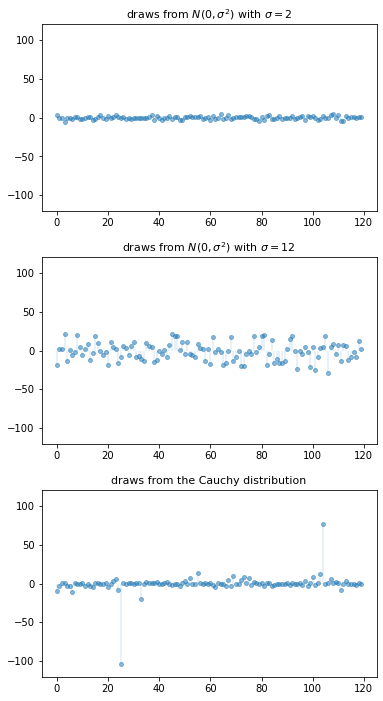

In [6]:
n = 120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"draws from $N(0, \sigma^2)$ with $\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"draws from the Cauchy distribution", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

### Exercise 2

Let $ X $ have a Pareto tail with tail index $ \alpha $ and let $ F $ be its cdf.

Fix $ r \geq \alpha $.

As discussed after [(7.4)](#equation-plrt), we can take positive constants $ b $ and $ \bar x $ such that

$$
\mathbb P\{X > x\} \geq b x^{- \alpha} \text{ whenever } x \geq \bar x
$$

But then

$$
\mathbb E X^r = r \int_0^\infty x^{r-1} \mathbb P\{ X > x \} x
\geq
r \int_0^{\bar x} x^{r-1} \mathbb P\{ X > x \} x
+ r \int_{\bar x}^\infty  x^{r-1} b x^{-\alpha} x.
$$

We know that $ \int_{\bar x}^\infty x^{r-\alpha-1} x = \infty $ whenever $ r - \alpha - 1 \geq -1 $.

Since $ r \geq \alpha $, we have $ \mathbb E X^r = \infty $.

### Exercise 3

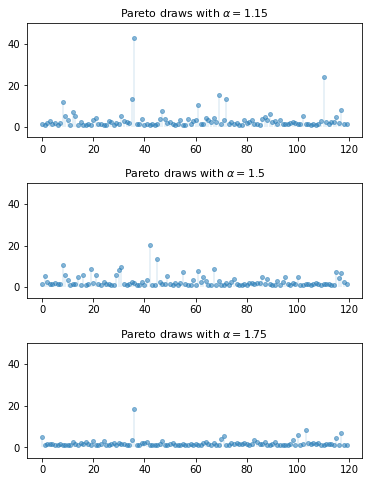

In [7]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"Pareto draws with $\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

### Exercise 4

First let’s generate the data for the plots:

In [8]:
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

data_1 = np.abs(z)
data_2 = np.exp(z)
data_3 = np.exp(np.random.exponential(scale=1.0, size=sample_size))

data_list = [data_1, data_2, data_3]

Now we plot the data:

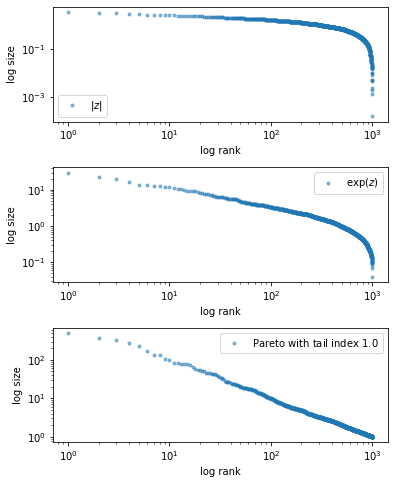

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['$|z|$', '$\exp(z)$', 'Pareto with tail index $1.0$']

for data, label, ax in zip(data_list, labels, axes):

    rank_data, size_data = qe.rank_size(data)

    ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("log rank")
    ax.set_ylabel("log size")

    ax.legend()

fig.subplots_adjust(hspace=0.4)

plt.show()

### Exercise 5

To do the exercise, we need to choose the parameters $ \mu $
and $ \sigma $ of the lognormal distribution to match the mean and median
of the Pareto distribution.

Here we understand the lognormal distribution as that of the random variable
$ \exp(\mu + \sigma Z) $ when $ Z $ is standard normal.

The mean and median of the Pareto distribution [(7.5)](#equation-pareto) with
$ \bar x = 1 $ are

$$
\text{mean } = \frac{\alpha}{\alpha - 1}
\quad \text{and} \quad
\text{median } = 2^{1/\alpha}
$$

Using the corresponding expressions for the lognormal distribution leads us to
the equations

$$
\frac{\alpha}{\alpha - 1} = \exp(\mu + \sigma^2/2)
\quad \text{and} \quad
2^{1/\alpha} = \exp(\mu)
$$

which we solve for $ \mu $ and $ \sigma $ given $ \alpha = 1.05 $.

Here is code that generates the two samples, produces the violin plot and
prints the mean and standard deviation of the two samples.

In [10]:
num_firms = 100_000
num_years = 10
tax_rate = 0.15
r = 0.05

β = 1 / (1 + r)    # discount factor

x_bar = 1.0
α = 1.05

def pareto_rvs(n):
    "Uses a standard method to generate Pareto draws."
    u = np.random.uniform(size=n)
    y = x_bar / (u**(1/α))
    return y

Let’s compute the lognormal parameters:

In [11]:
μ = np.log(2) / α
σ_sq = 2 * (np.log(α/(α - 1)) - np.log(2)/α)
σ = np.sqrt(σ_sq)

Here’s a function to compute a single estimate of tax revenue for a particular
choice of distribution `dist`.

In [12]:
def tax_rev(dist):
    tax_raised = 0
    for t in range(num_years):
        if dist == 'pareto':
            π = pareto_rvs(num_firms)
        else:
            π = np.exp(μ + σ * np.random.randn(num_firms))
        tax_raised += β**t * np.sum(π * tax_rate)
    return tax_raised

Now let’s generate the violin plot.

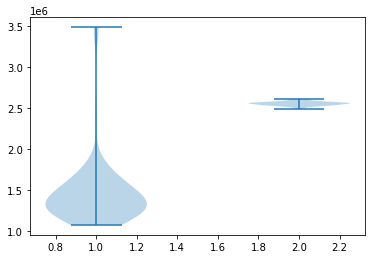

In [13]:
num_reps = 100
np.random.seed(1234)

tax_rev_lognorm = np.empty(num_reps)
tax_rev_pareto = np.empty(num_reps)

for i in range(num_reps):
    tax_rev_pareto[i] = tax_rev('pareto')
    tax_rev_lognorm[i] = tax_rev('lognorm')

fig, ax = plt.subplots()

data = tax_rev_pareto, tax_rev_lognorm

ax.violinplot(data)

plt.show()

Finally, let’s print the means and standard deviations.

In [14]:
tax_rev_pareto.mean(), tax_rev_pareto.std()

(1458729.0546623734, 406089.3613661567)

In [15]:
tax_rev_lognorm.mean(), tax_rev_lognorm.std()

(2556174.8615230713, 25586.44456513965)

Looking at the output of the code, our main conclusion is that the Pareto
assumption leads to a lower mean and greater dispersion.